# stLearn Cell-Cell Interaction Analysis

The overall steps in the stLearn cell-cell interaction (CCI) analysis pipeline are:

    1. Load known ligand-receptor gene pairs.
    2. Identify spots where significant interactions between these pairs occur.
    3. For each LR pair and each celltype-celltype combination, 
        count the instances where neighbours of a signficant spot 
        for that LR pair link two given cell types.
    4. Identify signficant interactions with p<.05 from cell type information permutation.
    5. Visualise the CCI results.

## Ligand-Receptor Analysis
The first step in the stLearn CCI pipeline is the ligand-receptor (LR) analysis. 

This analysis calls significant spots of ligand-receptor interactions from a database of candidate ligand-receptors.

Run-time will heavily depend on the dataset & compute resources available; note that multi-threading capability is implemented.

### Environment setup

In [1]:
import stlearn as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Loading & Preprocessing
Note we don't log1p the data for the LR analysis.

In [ ]:
# Loading raw data #
data = st.Read10X(data_dir)
data.var_names_make_unique()
st.add.image(adata=data,
             imgpath=data_dir+"spatial/tissue_hires_nobg.png",
             library_id="V1_Breast_Cancer_Block_A_Section_1", visium=True)

# Basic normalisation #
st.pp.filter_genes(data, min_cells=3)
st.pp.normalize_total(data) # NOTE: no log1p

['stroma' 'basal_like_1' 'stroma' ... 'basal_like_1' 'stroma'
 'basal_like_1']
                    basal_like_2  macrophage    stroma  basal_like_1  \
AAACAAGTATCTCCCA-1      0.114847    0.153870  0.517986      0.000000   
AAACACCAATAACTGC-1      0.157768    0.004139  0.071592      0.451562   
AAACAGAGCGACTCCT-1      0.202656    0.004635  0.647263      0.003862   
AAACAGGGTCTATATT-1      0.000000    0.082156  0.003555      0.000000   
AAACAGTGTTCCTGGG-1      0.565240    0.039651  0.205373      0.119639   
...                          ...         ...       ...           ...   
TTGTTGTGTGTCAAGA-1      0.134887    0.028774  0.024245      0.353047   
TTGTTTCACATCCAGG-1      0.031501    0.893722  0.000000      0.055103   
TTGTTTCATTAGTCTA-1      0.141504    0.032159  0.105041      0.462340   
TTGTTTCCATACAACT-1      0.065008    0.000000  0.934992      0.000000   
TTGTTTGTGTAAATTC-1      0.000000    0.000000  0.000000      0.601054   

                    mesenchymal  luminal_ar  mesenchymal

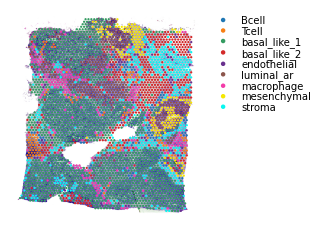

In [3]:
# Adding the label transfer results,  #
spot_mixtures = pd.read_csv(data_dir+'../../Brad/label_transfer_bc.csv', index_col=0, sep='\t')
labels = spot_mixtures.loc[:,'predicted.id'].values.astype(str)
spot_mixtures = spot_mixtures.drop(['predicted.id','prediction.score.max'],
                                   axis=1)
spot_mixtures.columns = [col.replace('prediction.score.', '')
                         for col in spot_mixtures.columns]

# Note the format! #
print(labels)
print(spot_mixtures)
print('Spot mixture order correct?: ', 
      np.all(spot_mixtures.index.values==data.obs_names.values)) # Check is in correct order

# NOTE: using the same key in data.obs & data.uns
data.obs['cell_type'] = labels # Adding the dominant cell type labels per spot
data.obs['cell_type'] = data.obs['cell_type'].astype('category')
data.uns['cell_type'] = spot_mixtures # Adding the cell type scores

st.pl.cluster_plot(data, use_label='cell_type')

For the above cell type information, note that these results were generated using Seurat. 

It's not necessary to have the cell type scores per spot; you can run with just discrete spot labels. 

However, if running with cell type scores, do need to add the dominant cell type to the adata.obs slot with the same key as the cell type scores added to the adata.uns slot; as exemplified above.

### Running the Ligand-Receptor Analysis

In [4]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))

# Running the analysis #
st.tl.cci.run(data, lrs,
                  min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                  distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=100, # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=4, # Number of CPUs for parallel. If None, detects & use all available.
                  )

lr_info = data.uns['lr_summary'] # A dataframe detailing the LR pairs ranked by number of significant spots.
print('\n', lr_info)

2293
Calculating neighbours...
0 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 1444 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████████████████████████████████████████████ [ time left: 00:00 ]



Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].

                n_spots  n_spots_sig  n_spots_sig_pval
THBS1_ITGB1       3550           12               321
SPON2_ITGB1       3297           11               268
LGALS1_ITGB1      3744           10               217
ANGPTL2_ITGB1     2687           10               305
LAMB1_ITGB1       3290           10               252
...                ...          ...               ...
CCL4_ACKR2          81            0                76
KISS1_KISS1R        24            0                23
KITLG_KIT          237            0               134
LGI1_ADAM11         29            0                26
ZP3_MERTK

### P-value adjustment
Below can adjust the p-value using different approaches; the p-value has already been corrected by running  st.tl.cci.run. This is what was used for the paper and is the default of the below function. The difference between correct_axis is adjusting by no. of LRs tested per spot (LR), no. of spots tested per LR (spot), or no adjustment (None). 

In [31]:
st.tl.cci.adj_pvals(data, correct_axis='spot',
                   pval_adj_cutoff=0.05, adj_method='fdr_bh') 

Updated adata.uns[lr_summary]
Updated adata.obsm[lr_scores]
Updated adata.obsm[lr_sig_scores]
Updated adata.obsm[p_vals]
Updated adata.obsm[p_adjs]
Updated adata.obsm[-log10(p_adjs)]


### Visualise the overall ranking of LRs by significant spots

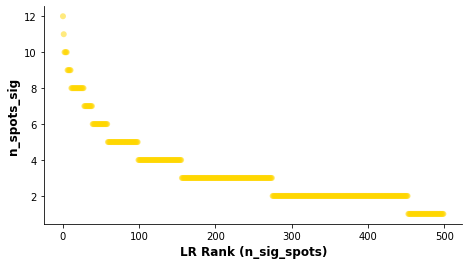

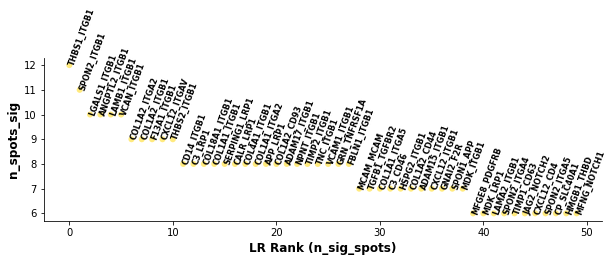

In [32]:
# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(data, n_top=500)
st.pl.lr_summary(data, n_top=50, figsize=(10,3))

## Diagnostic plots

A key aspect of the LR analysis is to control for LR expression level and frequency when calling significant hotspots. 

Hence, **our diagnostic plots should show next to no correlation between the hotspots of the LR pairs and the expression level and frequency of expression.**

The following diagnostics allow us to check and make sure this is the case; if not, could indicate a larger number of permutations is required. 

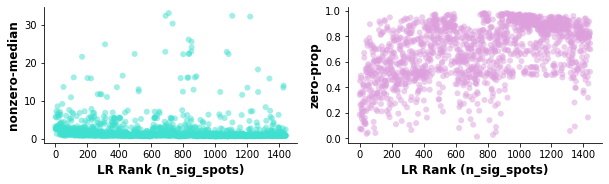

In [33]:
st.pl.lr_diagnostics(data, figsize=(10,2.5))

**Left plot**: Relationship between LR expression level (non-zero spots average median expression of genes in the LR pair) and the ranking of the LR.

**Right plot**: Relationship between LR expression frequency (average proportion of zero spots for each gene in the LR pair) and the ranking of the LR.

In this case, there is a weak correlation between the LR expression frequency and number of significant spots, indicating the n_pairs parameter should be set higher to create more accurate background distributions (10,000 pairs was used in the case of the paper version of the above).

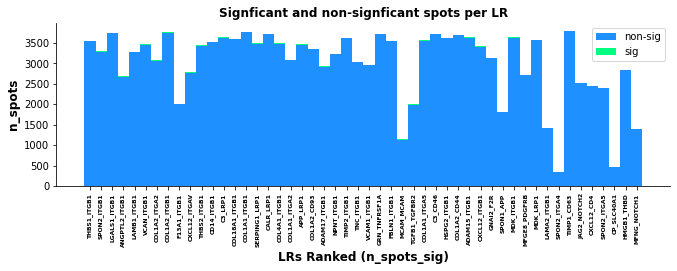

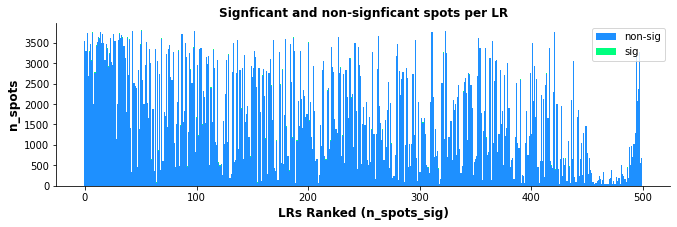

In [34]:
st.pl.lr_n_spots(data, n_top=50, figsize=(11, 3),
                    max_text=100)
st.pl.lr_n_spots(data, n_top=500, figsize=(11, 3),
                    max_text=100)

The above boxplots show the number of spots with ligand-receptor scores for each LR on the y-axis, with the LR ranking on the x-axis. The bar area is stratified by spots which were significant (green) and non-significant (blue). 

While the trend isn't as quantitative with this plot compared with the scatter plot, there does appear to be some correlation with more highly frequent LR pairs and LR ranking; again indicating the n_pairs parameter above should be set higher. 

### Biologic Plots (Optional)
Having examined whether we still see a correlation with the technical factors via diagnostic plots, 
**let's now examine whether we see biological enrichment of the genes in the top LR pairs** as a prognostic we are performing some biological inference.

For this to work, it requires R installed with clusterProfiler, org.Mm.eg.db, and org.Hs.eg.db.

To install R, we recommend using [conda](https://anaconda.org/conda-forge/r-base).
For the R dependencies, please see the following links for installation: [clusterProfiler](https://www.bioconductor.org/packages//2.10/bioc/html/clusterProfiler.html), [org.Hs.eg.db](https://bioconductor.org/packages/release/data/annotation/html/org.Hs.eg.db.html), [org.Mm.eg.db](https://bioconductor.org/packages/release/data/annotation/html/org.Mm.eg.db.html).

To get the path to your R installation, simply type the following into your terminal: **which R**

In [35]:
## Running the GO enrichment analysis ##
r_path = "/Library/Frameworks/R.framework/Resources"
st.tl.cci.run_lr_go(data, r_path)

GO results saved to adata.uns['lr_go']


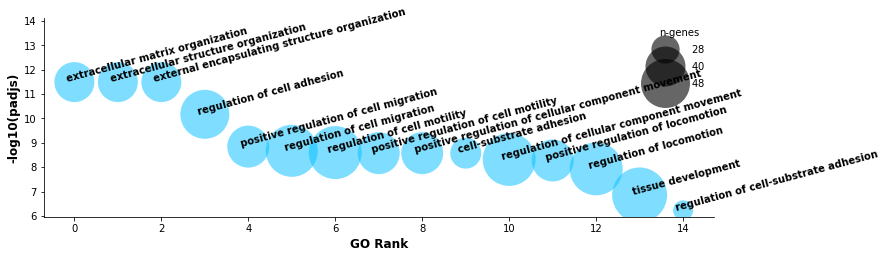

In [36]:
st.pl.lr_go(data, lr_text_fp={'weight': 'bold', 'size': 10}, rot=15,
               figsize=(12,3.65), n_top=15, show=False)

Overall, we see some strong biological enrichment, indicating some potential pathways mediated by the top LR pairs.

## LR Statistics Visualisations

The lr_result_plot displays LR analysis spot statistics for particular LR pairs in the spatial context.

Different values to plot are stored in .obsm, & include: **lr_scores, p_vals, p_adjs, -log10(p_adjs), lr_sig_scores**

In [37]:
best_lr = data.uns['lr_summary'].index.values[0] # Just choosing one of the top from lr_summary

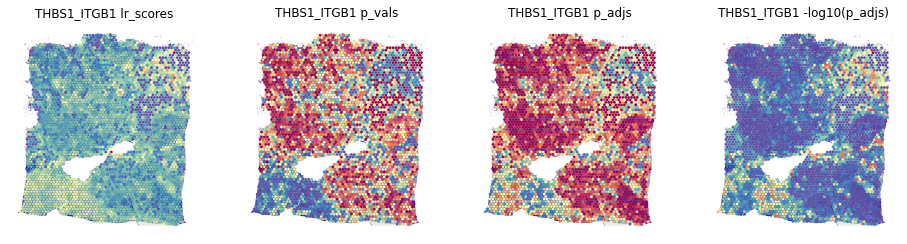

In [38]:
stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']
fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(data, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])
    axes[i].set_title(f'{best_lr} {stat}')

#### This shows the scores -log10(p_adjs) for all spots, then the scores subseted to significant spots

Text(0.5, 1.0, 'THBS1_ITGB1 lr_sig_scores')

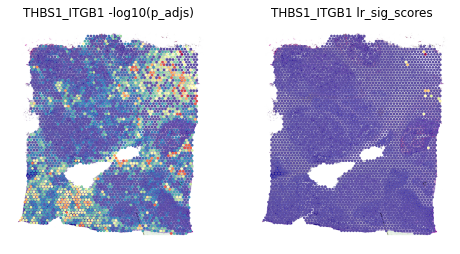

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6))
st.pl.lr_result_plot(data, use_result='-log10(p_adjs)', use_lr=best_lr, show_color_bar=False, ax=axes[0])
st.pl.lr_result_plot(data, use_result='lr_sig_scores', use_lr=best_lr, show_color_bar=False, ax=axes[1])
axes[0].set_title(f'{best_lr} -log10(p_adjs)')
axes[1].set_title(f'{best_lr} lr_sig_scores')

## LR Interpretation Visualisations

These visualisations are meant to help interpret the directionality of the cross-talk.

#### Binary LR coexpression plot for all spots

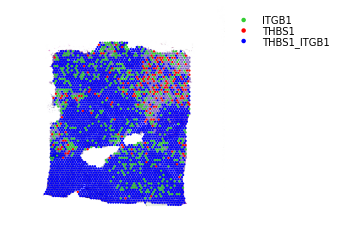

In [40]:
st.pl.lr_plot(data, best_lr, inner_size_prop=0.1, outer_mode='binary', pt_scale=5,
              use_label=None, show_image=True,
              sig_spots=False)

#### Binary LR coexpression plot for significant spots

Trying to set attribute `.obs` of view, copying.


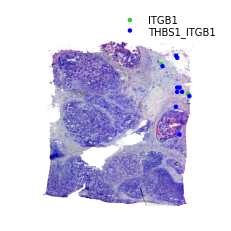

In [41]:
st.pl.lr_plot(data, best_lr, outer_size_prop=1, outer_mode='binary', pt_scale=20,
              use_label=None, show_image=True,
              sig_spots=True)

#### Continuous LR coexpression for significant spots

The receptor is in green, the ligand is in red.
The inner-point is the receptor, the outter point is the ligand.

Help to see where and how heavily expressed ligands/receptors are. 

Idea is receptor is on the cell surface, & ligand permeates out from the cell surface.

/Users/uqbbalde/Desktop/Uni_Studies/myPython/stlearn_latest/stLearn/stlearn/plotting/classes.py:185: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(plot, aspect=10, shrink=0.5, cmap=self.cmap,


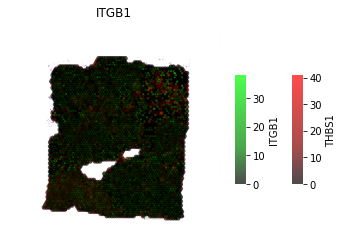

In [42]:
# All spots #
st.pl.lr_plot(data, best_lr,
              inner_size_prop=0.04, middle_size_prop=.07, outer_size_prop=.4,
              outer_mode='continuous', pt_scale=60,
              use_label=None, show_image=True,
              sig_spots=False)

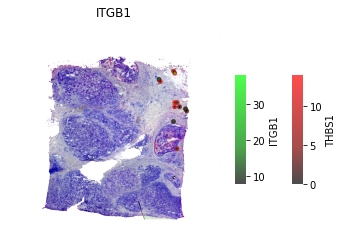

In [43]:
# Only significant spots #
st.pl.lr_plot(data, best_lr,
              inner_size_prop=0.04, middle_size_prop=.07, outer_size_prop=.4,
              outer_mode='continuous', pt_scale=60,
              use_label=None, show_image=True,
              sig_spots=True)

#### Adding Arrows to show the Direction of Interaction
This is only useful when zooming in and want to display cell information and direction of interaction at the same time. 

Trying to set attribute `.obs` of view, copying.


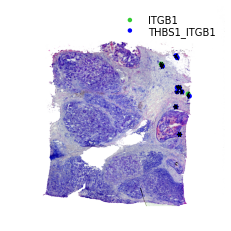

In [44]:
st.pl.lr_plot(data, best_lr,
              inner_size_prop=0.08, middle_size_prop=.3, outer_size_prop=.5,
              outer_mode='binary', pt_scale=50,
              show_image=True, arrow_width=10, arrow_head_width=10,
              sig_spots=True, show_arrows=True)

#### Binary LR coexpression with Spot Annotations

We can also visualise where the ligand or receptor are expressed/coexpressed simultaneously with the dominant spot cell type.

The outter spot shows the expression of ligand (red), the receptor (green), and coexpression (blue). 
The inner spot is coloured by the dominant spot cell type.

Trying to set attribute `.obs` of view, copying.


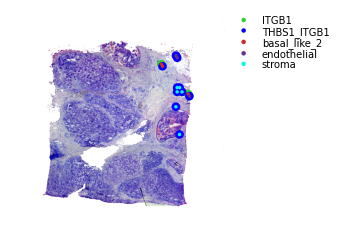

In [45]:
st.pl.lr_plot(data, best_lr,
              inner_size_prop=0.08, middle_size_prop=.3, outer_size_prop=.5,
              outer_mode='binary', pt_scale=150,
              use_label='cell_type', show_image=True,
              sig_spots=True)

## Predicting significant CCIs

With the establishment of significant areas of LR interaction, can now determine the significantly interacting cell types.

In [46]:
# Running the counting of co-occurence of cell types and LR expression hotspots #
st.tl.cci.run_cci(data, 'cell_type', # Spot cell information either in data.obs or data.uns
                  min_spots=3, # Minimum number of spots for LR to be tested.
                  spot_mixtures=True, # If True will use the label transfer scores,
                                      # so spots can have multiple cell types if score>cell_prop_cutoff
                  cell_prop_cutoff=0.2, # Spot considered to have cell type if score>0.2
                  sig_spots=True, # Only consider neighbourhoods of spots which had significant LR scores.
                  n_perms=100 # Permutations of cell information to get background, recommend ~1000
                 )

Significant counts of cci_rank interactions for all LR pairs in lr_cci_cell_type
Significant counts of cci_rank interactions for each LR pair stored in dictionary per_lr_cci_cell_type


## Diagnostic plot: check interaction and cell type frequency correlation
The plot below should show little to no correlation if the number of permutations is adequate; otherwise recommend increasing n_perms above.

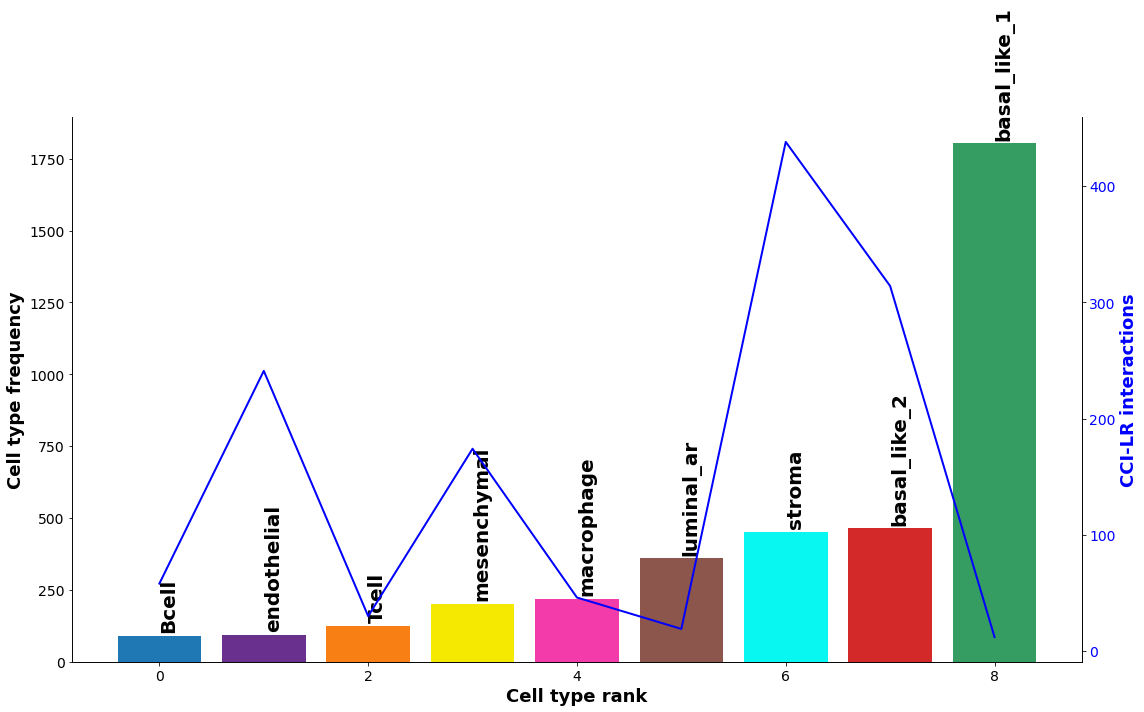

In [47]:
st.pl.cci_check(data, 'cell_type')

## CCI Visualisations

With the celltype-celltype predictions completed, we implement a number of visualisations to explore the interaction landscape across LR pairs or for each independent pair. 

### CCI network
The below shows the stlearn version of a CCI network. 

If you're more comfortable with visualisations in R, it's possible to save the adjacency matrix that generates this network from the anndata object and use visualisation functions from CellChat to make R-based visualisations.

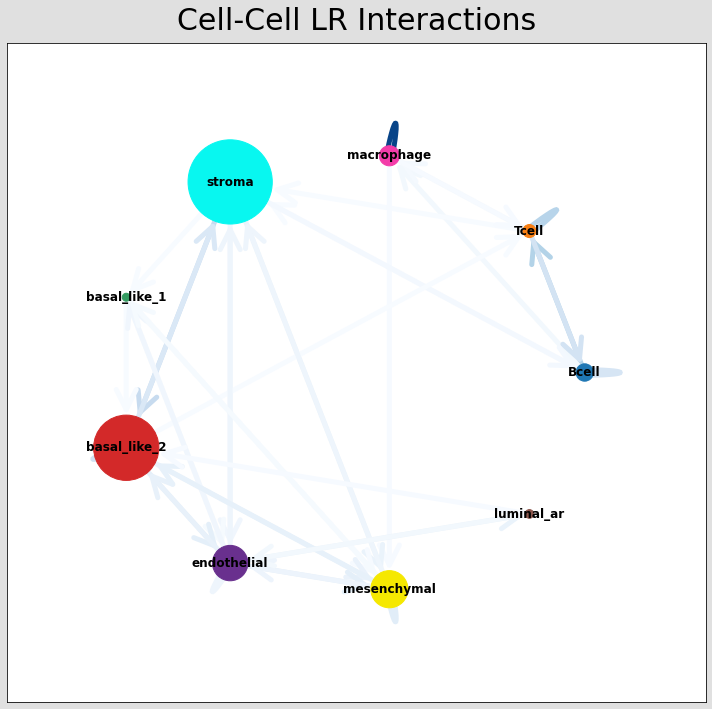

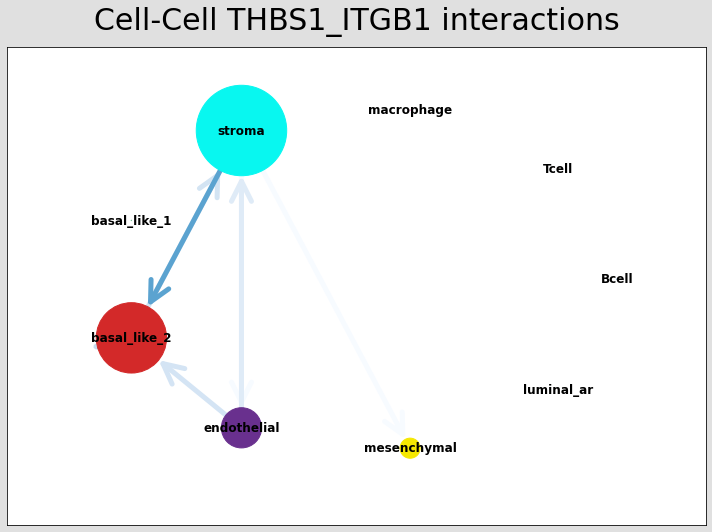

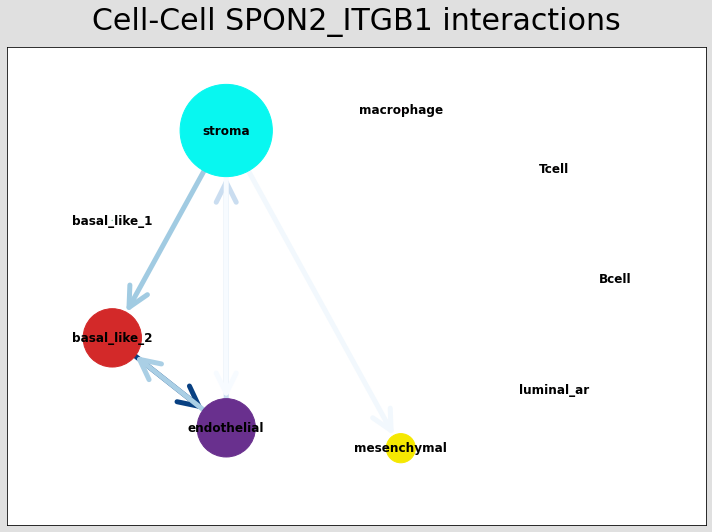

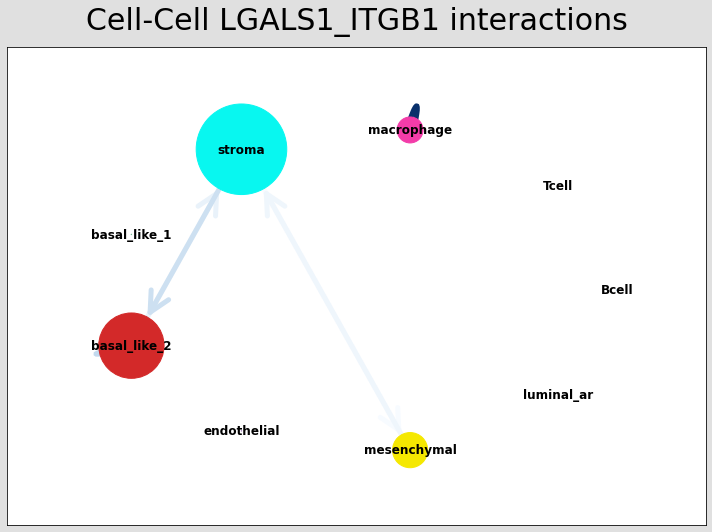

In [48]:
# Visualising the no. of interactions between cell types across all LR pairs #
pos_1 = st.pl.ccinet_plot(data, 'cell_type', return_pos=True)

# Just examining the cell type interactions between selected pairs #
lrs = data.uns['lr_summary'].index.values[0:3]
for best_lr in lrs[0:3]:
    st.pl.ccinet_plot(data, 'cell_type', best_lr, min_counts=2,
                         figsize=(10,7.5), pos=pos_1,
                      )

### CCI chord-plot
The chord-plot is really useful when visualising interactions between few cell types

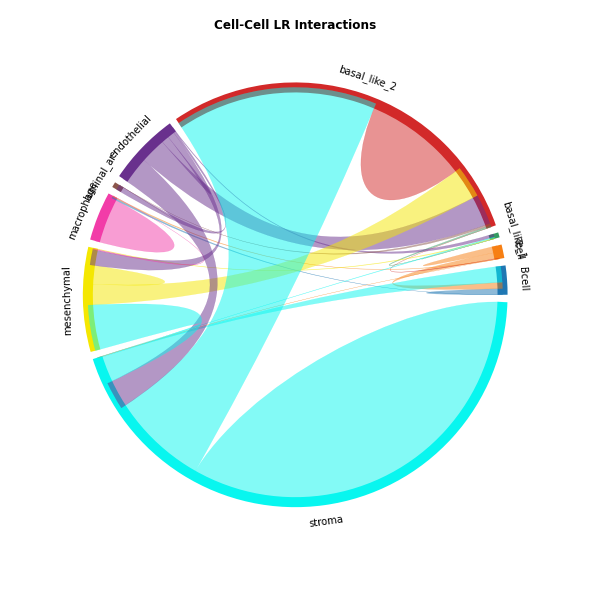

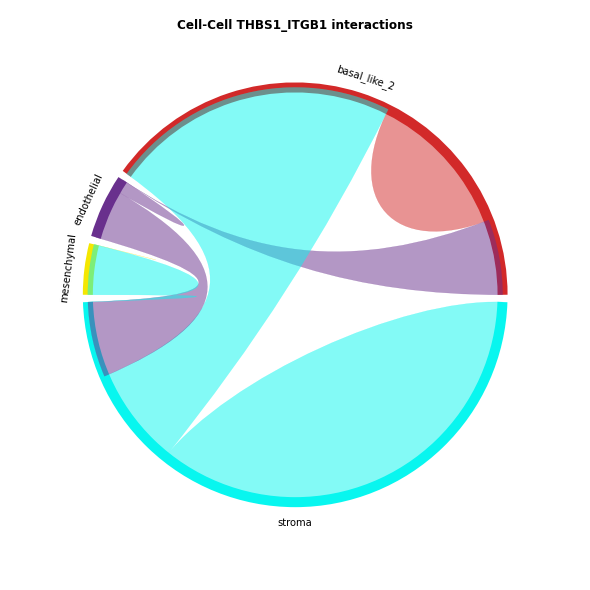

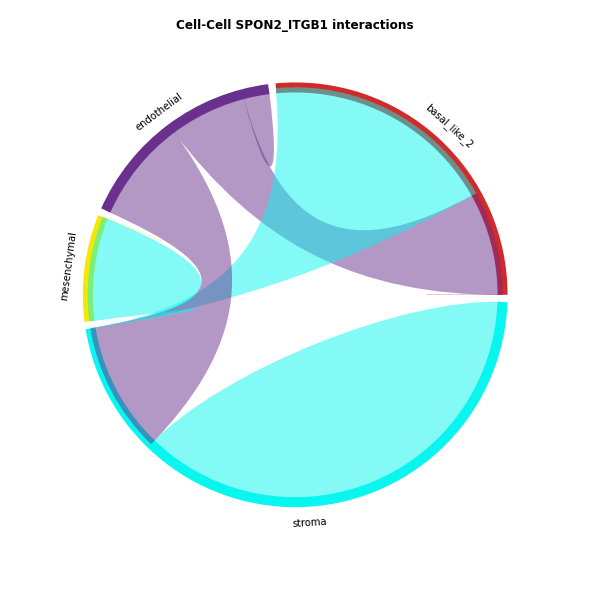

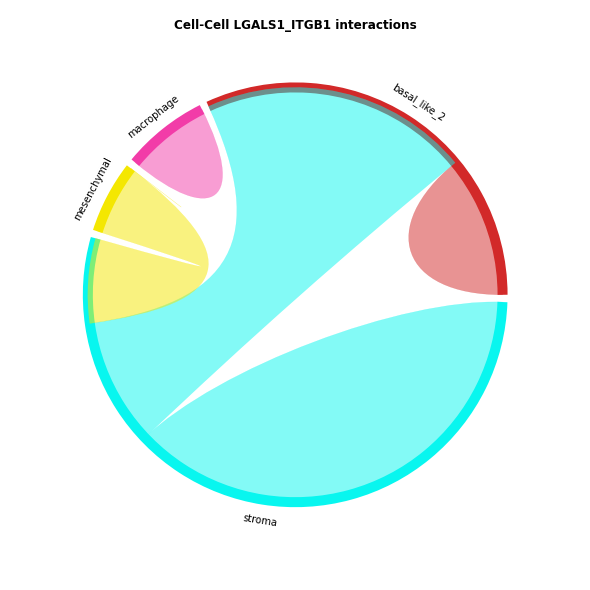

In [49]:
st.pl.lr_chord_plot(data, 'cell_type')

for lr in lrs:
    st.pl.lr_chord_plot(data, 'cell_type', lr)

### Heatmap Visualisations

#### LR-CCI-Map
We also impliment a number of heatmap visualisations so you can visualise individual celltype-celltype interactions across multiple LR pairs concurrently. 

<AxesSubplot:xlabel='Cell-cell interaction', ylabel='LR-pair'>

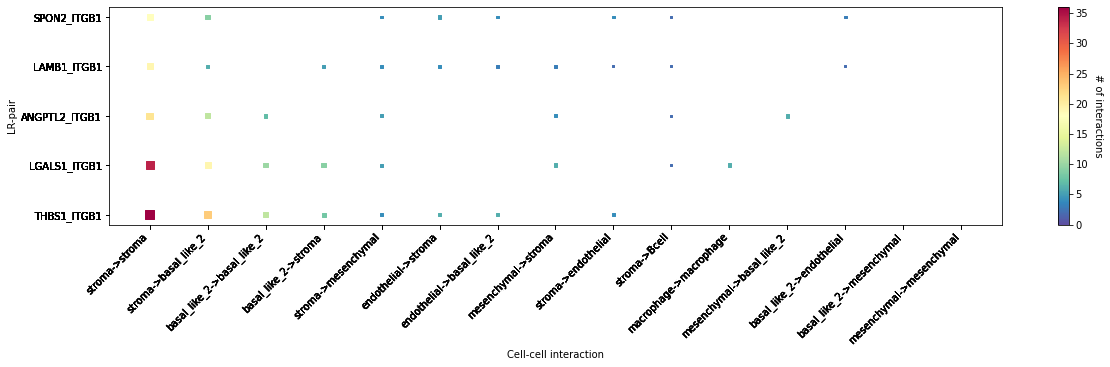

In [50]:
# This will automatically select the top interacting CCIs and their respective LRs #
st.pl.lr_cci_map(data, 'cell_type', lrs=None, min_total=100, figsize=(20,4))

<AxesSubplot:xlabel='Cell-cell interaction', ylabel='LR-pair'>

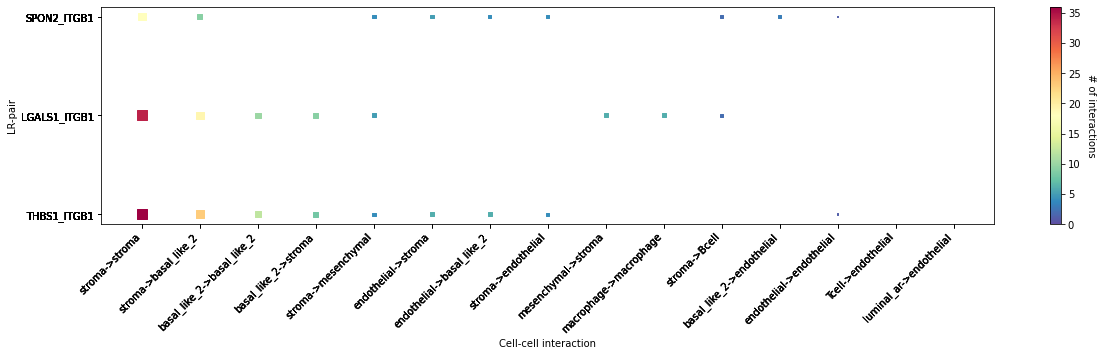

In [52]:
# You can also put in your own LR pairs of interest #
st.pl.lr_cci_map(data, 'cell_type', lrs=lrs, min_total=100, figsize=(20,4))

#### CCI Maps
This is a heatmap equivalent to the network diagrams and chordplots, it has more quantitative benefits.

The **# of interactions** refers to the number of times a spot with the reciever cell type expressed the ligand and the source cell type expressed the receptor in the same neighbourhood.

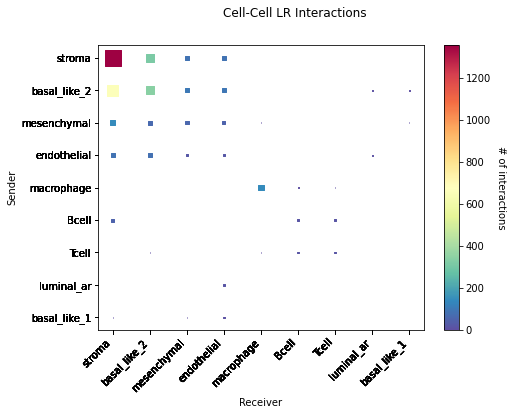

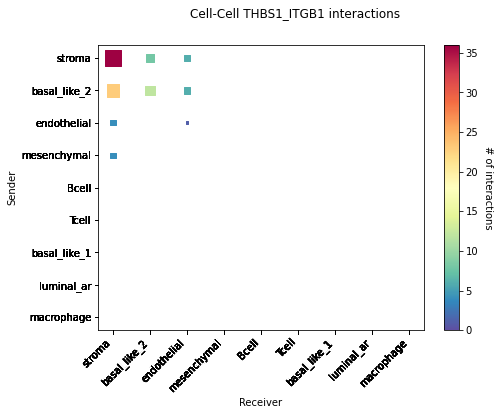

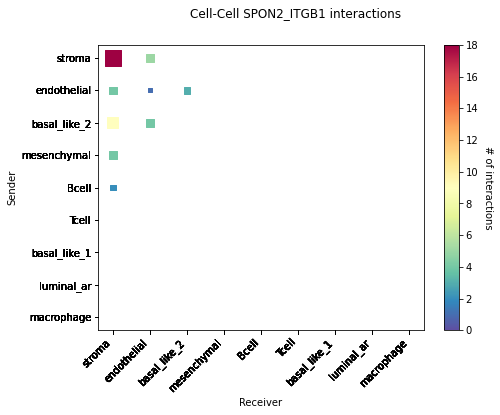

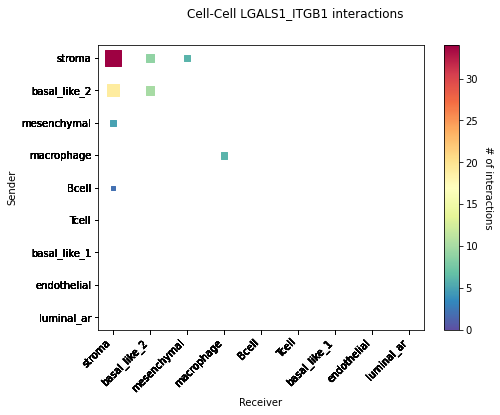

In [53]:
st.pl.cci_map(data, 'cell_type')

lrs = data.uns['lr_summary'].index.values[0:3]
for lr in lrs[0:3]:
    st.pl.cci_map(data, 'cell_type', lr)

## Spatial cell type interactions

By combining the spatial LR analysis with the significant CCI from the CCI analysis, we can now visualise where in the tissue these cell types are interacting. 

The recommended method for this is to plot the cell types, and overlay arrows indicating spots that express the ligand and spots that express the receptor. 

This way can see **- at spot level in the spatial context -** where the different cell types interact and via a given ligand-receptor pair. 

#### NOTE: the will need to be zoom-in to be visualised properly, very useful for showing particular regions of interest.

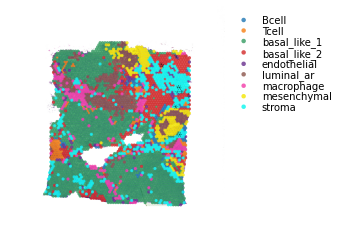

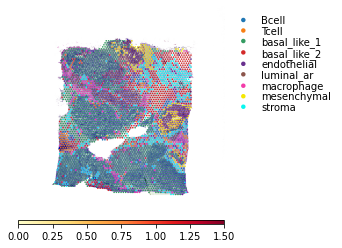

In [54]:
best_lr = lrs[0]

### This will plot with simple black arrows ####
st.pl.lr_plot(data, best_lr, outer_size_prop=1, outer_mode=None,
              pt_scale=40, use_label='cell_type', show_arrows=True,
              show_image=True, sig_spots=False, sig_cci=True,
                 arrow_head_width=4,
                 arrow_width=1, cell_alpha=.8
                 )

### This will colour the spot by the mean LR expression in the spots connected by arrow
st.pl.lr_plot(data, best_lr, outer_size_prop=1, outer_mode=None,
              pt_scale=10, use_label='cell_type', show_arrows=True,
              show_image=True, sig_spots=False, sig_cci=True,
                 arrow_head_width=4, arrow_width=2,
                 arrow_cmap='YlOrRd', arrow_vmax=1.5,
                 )

## Visualisation Tips

CCIs in the spatial context are very high-dimensional and information rich. Which of the above visualisation will be useful will depend on the biology and key aspect you wish to highlight. 

In our experience, it's useful to show the LR statistics for LRs of interest, and then plot with the cell type information and the arrows. 

In the latter plot, it's best to highlight regions of interest (like the arrows above) which are then shown zoomed-in. Thus allowing you to highlight representative areas where interesting CCIs are predicted to occur. 

Stlearn interactive is a great way to rapidly do this, see here for the github: https://github.com/BiomedicalMachineLearning/stlearn_interactive/

Here for the tutorial:
https://github.com/BiomedicalMachineLearning/stlearn_interactive/blob/brad_dev/docs/stlearn_interactive_tutorial.pdf